# Kaggle - Titanic - Machine Learning from Disaster - Part 2

In this exercise you will update your submission to the titanic competition.

a) First let's add new numerical features / columns to the datasets that might be related to the survival of individuals.

- `has_cabin` should have a value of 0 if the `cabin` feature is `nan` and 1 otherwise
- `family_members` should have the total number of family members (by combining `SibSp` and `Parch`)
- `title_type`: from the title extracted from the name, we will categorize it into 2 types: `common` for titles that many passengers have, `rare` for titles that few passengers have. Map `common` to 1 and `rare` to 0. Describe what threshold you used to define `common` and `rare` titles and how you found it.
- `fare_type`: using Kmeans clustering on the fare column, find an appropriate number of clusters / groups of similar fares. Using the clusters you created, `fare_price` should be an ordinal variable that represents the expensiveness of the fare. For example if you split fare into 3 clusters ( 0 - 15, 15 - 40, and 40+ ) then the `fare_price` value should be `0` for `fare` values 0 - 15, `1` for 15 - 40, and `2` for 40+.
- Create an addition two numerical features of your invention that you think could be relevant to the survival of individuals.

Note: The features must be numerical because the sklearn `DecisionTreeClassifier` can only take on numerical features.

In [1383]:
import pandas as pd
import numpy as np

train_Data_DF = pd.read_csv("./Data/train.csv")
test_Data_DF = pd.read_csv("./Data/test.csv")

- The has_cabin feature could tell us whether having a cabin or not influenced whether a person survived or not.

- Family_members is a combination of SibSp and Parch plus 1 (for the passenger themselves). This feature can be useful to understand if having family members on board affects a passenger's survival rate.

In [1384]:
for df in [train_Data_DF, test_Data_DF]:
     # Set 'has_cabin' to 1 if 'Cabin' is not null, 0 otherwise
    df['has_cabin'] = np.where(df['Cabin'].notnull(), 1, 0)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

For title_type like last time we'll use regex first to extract them:

- train_Data_DF['Name'] accesses the Name column in the training DataFrame.

- .str.extract(' ([A-Za-z]+)\.', expand=False) applies the regular expression to each name, extracting the title.
    - (space): The search starts after a space, ensuring we don't start extracting from the beginning of the Lastname.

    - ([A-Za-z]+): This part captures one or more (+) alphabetical characters (A-Za-z). This is where the title will be matched, as titles are made up of letters only.
    
    - \.: This looks for a literal period (.). Titles in the dataset are followed by a period (e.g., "Mr."), making this a reliable way to end the capture.

- The extracted title is then assigned to a new column in the DataFrame called 'Title'.



In [1385]:
# Extract titles from the Name column
train_Data_DF['Title'] = train_Data_DF['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_Data_DF['Title'] = test_Data_DF['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [1386]:
for df in [train_Data_DF, test_Data_DF]:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Master'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace(['Miss', 'Mrs', 'Mr'], 'Common')

The code provided does a few things (same as the first notebook):

- It first replaces rare titles (like 'Lady', 'Countess', 'Capt', 'Col', etc.) with 'Rare'. This groups various titles of nobility or uncommon professional titles into a single 'Rare' category, acknowledging their unique status without overcomplicating the model.

- It replaces titles with their common equivalents, such as converting 'Mlle' and 'Ms' to 'Miss', and 'Mme' (Madame) to 'Mrs', to ensure consistency in the dataset.

- The distinction is that we are combining the titles into either rare or common as per the requirements. However I do think slightly more variation would benefit the model.

## Kmeans Clustering on Fare

First the distinction on fare type and fare price:

- fare_type: This column represents the cluster labels assigned by the KMeans algorithm based on the Fare value for each passenger. These labels are integers (0, 1, 2, ..., N-1, where N is the number of clusters) that indicate the cluster each passenger's fare belongs to. However, these labels are assigned based on the clustering algorithm's internal logic and do not necessarily correspond to the ordinal ranking of the fare amounts. For example, cluster 0 could correspond to the highest fare values, cluster 1 to the lowest, and cluster 2 to the medium, depending on how the clustering algorithm groups the data.

- fare_price: This column is derived from the fare_type labels and represents an ordinal variable that ranks the expensiveness of the fare from least to most expensive. The transformation from fare_type to fare_price involves sorting the cluster centers (average fare values of each cluster) to understand which cluster corresponds to which level of fare expensiveness. Then, a mapping is applied to convert the cluster labels (fare_type) into a meaningful ordinal sequence (fare_price). This means if cluster 2 has the lowest average fare, it would be mapped to 0 in fare_price, indicating the least expensive tier of fares.

In essence, fare_type is an intermediate step that assigns each passenger to a cluster based on fare, but it doesn't inherently order these clusters by the average fare within them. fare_price takes the additional step of ordering these clusters to create a meaningful, ordinal categorization of fare expensiveness.



In [1387]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Step 1: Determine the number of clusters using the elbow method
# Extract the Fare column values as a matrix
fare_values_train = train_Data_DF['Fare'].values.reshape(-1, 1)



### What is Inertia?
Inertia, in the context of KMeans, quantifies how far away the points within a cluster are from their centroid. A lower inertia value indicates that the points in each cluster are closer to each other and to their respective centroid, suggesting a better fit of the model to the data. However, as the number of clusters k increases, inertia naturally decreases because the clusters get smaller and their centers are closer to the points within them.

### Purpose of Calculating Inertia for Different k Values
The purpose of calculating and plotting the inertia for different k values is to apply the elbow method to determine the optimal number of clusters. When you plot the inertias (y-axis) against the number of clusters k (x-axis), you look for an "elbow" point where the rate of decrease of inertia sharply changes. Before this point, adding more clusters significantly reduces inertia, suggesting that the additional cluster provides a better fit to the data. After this point, the reduction in inertia slows down, indicating that additional clusters do not contribute as much to explaining the data variance and might lead to overfitting.

In [1388]:
# Calculate the sum of squared distances for different numbers of clusters
ssd = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(fare_values_train)
    ssd.append(kmeans.inertia_)

/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

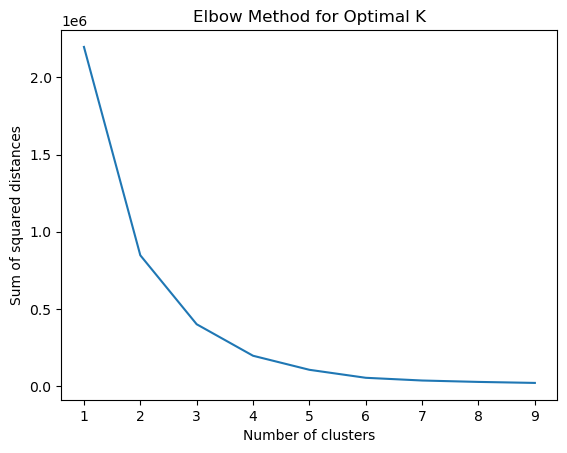

In [1389]:
# Plot the elbow curve
plt.plot(range(1, 10), ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal K')
plt.show()

At around 4 clusters the change of ssd starts to diminish and increasing clusters at that point may lead to overfitting.

In [1390]:
# Step 2: Fit KMeans with the chosen number of clusters (e.g., 3 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(fare_values_train)

train_Data_DF['fare_type'] = kmeans.predict(fare_values_train)


/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [1391]:
from sklearn.impute import SimpleImputer

# Apply the same transformation to the test data
# Test data has missing values so have to fill in those values
# using the median to try and avoid affecting the data too much

imputer = SimpleImputer(strategy="median")

# Fit the imputer on the training data
# on the training data to avoid data leakage
imputer.fit(train_Data_DF['Fare'].values.reshape(-1, 1))

fare_values_test = imputer.transform(test_Data_DF['Fare'].values.reshape(-1, 1))
test_Data_DF['fare_type'] = kmeans.predict(fare_values_test)

In [1392]:
# Step 3: Sort the clusters and map them to ordinal values
# Get the cluster centers and sort by fare
sorted_centers = sorted(kmeans.cluster_centers_.flatten())

# Map the cluster labels to ordinal values
# basically creating a relationshio between the original
# cluster label and the new ranking
ordinal_mapping = {sorted_centers.index(center): rank for rank, center in enumerate(sorted_centers)}
print(ordinal_mapping)

{0: 0, 1: 1, 2: 2, 3: 3}


In the case where ordinal_mapping is {0: 0, 1: 1, 2: 2, 3: 3}, it seems like a direct mapping because the cluster labels already coincide with their sorted order based on the fare. However, the mapping ensures that regardless of how the cluster labels were originally assigned by KMeans, each passenger's fare is categorized correctly according to the expensiveness ranking determined by the sorted cluster centers.

In [1393]:
# Apply the ordinal mapping to both training and test datasets
train_Data_DF['fare_price'] = train_Data_DF['fare_type'].map(ordinal_mapping)
test_Data_DF['fare_price'] = test_Data_DF['fare_type'].map(ordinal_mapping)

# Check the mapping
print(train_Data_DF[['Fare', 'fare_type', 'fare_price']].head())
print(test_Data_DF[['Fare', 'fare_type', 'fare_price']].head())

      Fare  fare_type  fare_price
0   7.2500          0           0
1  71.2833          2           2
2   7.9250          0           0
3  53.1000          2           2
4   8.0500          0           0
      Fare  fare_type  fare_price
0   7.8292          0           0
1   7.0000          0           0
2   9.6875          0           0
3   8.6625          0           0
4  12.2875          0           0


Now lets check what the ranges are.

In [1394]:
# Group the data by 'fare_type' (cluster label)
grouped = train_Data_DF.groupby('fare_type')

# Calculate min and max 'Fare' for each cluster
fare_ranges = grouped['Fare'].agg(['min', 'max'])

print(fare_ranges)

                min       max
fare_type                    
0            0.0000   42.4000
1          146.5208  263.0000
2           46.9000  135.6333
3          512.3292  512.3292


When looking at the ranges, it seems 4 clusters may be overfitting? As the fourth cluster seems to be for a single point.

Let me add columns for the mean Fare and the count of passengers (count) in each cluster,to provide a more comprehensive overview of the fare distribution within each cluster identified by KMeans model.

In [1395]:
fare_stats = grouped['Fare'].agg(['min', 'max', 'mean', 'count'])
print(fare_stats)

                min       max        mean  count
fare_type                                       
0            0.0000   42.4000   15.053373    720
1          146.5208  263.0000  204.948064     28
2           46.9000  135.6333   75.571339    140
3          512.3292  512.3292  512.329200      3


The fourth cluster, with only 3 data points and a significantly higher fare mean, represents outliers or a very distinct group of fares (in this case, the maximum fare of 512.3292). Since it does contain information about a few high value passengers it may be useful to keep.

### 2 more numerical columns

is alone like last time:
- df['IsAlone'] = 0 initializes a new column IsAlone for every passenger in the DataFrame, setting it to 0 by default, indicating that passengers are not alone.

- df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 this line looks for passengers whose FamilySize equals 1—meaning they have no family members aboard—and sets their IsAlone status to 1, indicating they are traveling alone.


In [1396]:
for df in [train_Data_DF, test_Data_DF]:
    df['IsAlone'] = 0 # Initially, assume no passengers are alone
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 # If FamilySize is 1, the passenger is alone


Age Group (Age-related Feature)

In [1397]:
def age_group(row):
    if row['Age'] <= 15:
        return 0  # Child
    elif row['Age'] <= 60:
        return 1  # Adult
    else:
        return 2  # Senior

train_Data_DF['age_group'] = train_Data_DF.apply(age_group, axis=1)
test_Data_DF['age_group'] = test_Data_DF.apply(age_group, axis=1)

### Applying One-Hot Encoding to the Titanic Dataset

In [1398]:
train_Data_DF = pd.get_dummies(train_Data_DF, columns=['Sex'], drop_first=True)
test_Data_DF = pd.get_dummies(test_Data_DF, columns=['Sex'], drop_first=True)

In [1399]:
train_Data_DF = pd.get_dummies(train_Data_DF, columns=['Embarked'], prefix='Embarked')
test_Data_DF = pd.get_dummies(test_Data_DF, columns=['Embarked'], prefix='Embarked')

In [1400]:
print(train_Data_DF.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   
5                                   Moran, Mr. James   NaN      0      0   
6                            McCarthy, Mr. Timothy J  54.0      0      

Cabin has a lot of empty fields want to drop for now aswell

In [1401]:
train_Data_DF = train_Data_DF.drop('Cabin', axis=1)
test_Data_DF = test_Data_DF.drop('Cabin', axis=1)

## Decision Trees

b) Using a method covered in class, tune the parameters of a decision tree model on the titanic dataset (containing all numerical features including the ones you added above). Evaluate this model locally and report it's performance.

Note: make sure you are not tuning your parameters on the same dataset you are using to evaluate the model. Also explain how you know you are not overfitting to the training set.


Simple Tree Code we have written in class

In [1402]:
class Node:
    def __init__(self, attribute):
        self.attr = attribute
        self.left = None
        self.right = None
        self.vote = None
    
    def _node_at(self, depth):
        pretty_print = ""
        if self.left is not None:
            for _ in range(depth):
                pretty_print += "| "
            pretty_print += self.attr + ' = 0: \n'
            pretty_print += self.left._node_at(depth + 1)
    
        if self.right is not None:
            for _ in range(depth):
                pretty_print += "| "
            pretty_print += self.attr + ' = 1: \n'
            pretty_print += self.right._node_at(depth + 1)
        
        if self.right is None and self.left is None:
            for _ in range(depth):
                pretty_print += "| "
            pretty_print += "vote = " + str(self.vote) + '\n'
        
        return pretty_print

    def __repr__(self):
        return self._node_at(0)

def gini(node):
    x = sum(node)
    if len(node) == 0:
        return 0
    frequencies = [
        x/len(node),
        (len(node) - x)/len(node) # could also do 1 - (x/len(node))
    ]
    return 1 - sum([f**2 for f in frequencies])


def predict(tree : Node, example):
    if tree.left is None and tree.right is None:
        return tree.vote
    
    if example[tree.attr] == 0:
        return predict(tree.left, example)

    if example[tree.attr] == 1:
        return predict(tree.right, example)

    return 0

#for multiple examples
def predict_batch(tree_model, data):
    predictions = []
    for _, row in data.iterrows():
        predictions.append(predict(tree_model.tree, row))
    return predictions

In [1403]:

class SimpleDecisionTree:
    
    def __init__(self, max_depth, data, target_name):
        self.max_depth = max_depth
        self.data = data
        self.target_name = target_name
        self.tree = None
        self.default_class = None


    def __repr__(self):
        return self.tree.__repr__()


    def get_subset(self, data, attr):
        subset_1 = data[data[attr] == 0]
        subset_2 = data[data[attr] == 1]
        return subset_1, subset_2


    def gini_split(self, data, attr):
        subsets = [
            data[data[attr] == 0][self.target_name],
            data[data[attr] == 1][self.target_name]
        ]
        if len(data) == 0:
            return 0

        return sum([gini(x)* len(x) for x in subsets])/len(data)


    def get_majority_vote(self, data):
        # Initialize a dictionary to count occurrences
        
        counts = {}
        # Iterate through each item in the target column
        for value in data[self.target_name]:
            if value in counts:
                counts[value] += 1
            else:
                counts[value] = 1
        print(counts)

        if counts:  # Ensure 'counts' is not empty
            majority_vote = max(counts, key=counts.get)
        else:
            majority_vote = self.default_class  # Fallback to the default class if no data
        #Find the key with the maximum value (majority vote)
        #majority_vote = max(counts, key=counts.get)
        return majority_vote


    def get_best_attribute(self, data):        
        best_attr = None
        min_gini = float('inf')
        for attr in data.columns:
            if attr != self.target_name:
                gini = self.gini_split(data, attr)

                if gini < min_gini:
                    min_gini = gini
                    best_attr = attr
        return best_attr

    # added print statements

    def build_tree(self, data, depth):
        if depth == 0 or len(data) == 0:
            # Create a leaf node with the majority vote
            node = Node(None)  # No splitting attribute since it's a leaf
            node.vote = self.get_majority_vote(data)
            print(f"Leaf node created with vote={node.vote} at depth={self.max_depth - depth}")
            return node

        # Select the best attribute to split on
        attr = self.get_best_attribute(data)
        if attr is None:
            # If no attribute is found, create a leaf node
            node = Node(None)
            node.vote = self.get_majority_vote(data)
            return node

        # Create a node for the selected attribute
        node = Node(attr)
        print(f"Creating node with attribute '{attr}' at depth={self.max_depth - depth}")

        # Split the data based on the best attribute
        left_data, right_data = self.get_subset(data, attr)

        # Recursively build the left and right subtrees
        node.left = self.build_tree(left_data, depth - 1)
        node.right = self.build_tree(right_data, depth - 1)

        return node



    def train(self):
        # Adjusted to work with pandas DataFrame
        if self.max_depth > len(self.data.columns) - 1:
            self.max_depth = len(self.data.columns) - 1

        self.default_class = self.get_majority_vote(self.data)
        self.tree = self.build_tree(self.data, self.max_depth)



Now to train the dataset on the decision tree

In [1404]:
# Dropping non-numeric and target columns
X = train_Data_DF.drop(['PassengerId', 'Name', 'Ticket', 'Title', 'Survived', 'Age','Fare'], axis=1)
y = train_Data_DF['Survived']

In [1405]:
print(X.head())

   Pclass  SibSp  Parch  has_cabin  FamilySize  fare_type  fare_price  \
0       3      1      0          0           2          0           0   
1       1      1      0          1           2          2           2   
2       3      0      0          0           1          0           0   
3       1      1      0          1           2          2           2   
4       3      0      0          0           1          0           0   

   IsAlone  age_group  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0        0          1         1           0           0           1  
1        0          1         0           1           0           0  
2        1          1         0           0           0           1  
3        0          1         0           0           0           1  
4        1          1         1           0           0           1  


In [1406]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1407]:
# The range of 'max_depth' values to explore
max_depths = range(1, 10) # arbritrary range
best_accuracy = 0
best_depth = 0

for depth in max_depths:
    # Initialize and train the SimpleDecisionTree with the current 'max_depth'
    tree = SimpleDecisionTree(max_depth=depth, data=X_train.assign(Survived=y_train), target_name='Survived')
    tree.train()

    # Assuming a 'predict' method is implemented to make predictions with the trained tree
    predictions = predict_batch(tree, X_test)
    accuracy = (predictions == y_test).mean()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print(f"Best Depth: {best_depth}, Best Accuracy: {best_accuracy}")

{0: 444, 1: 268}
Creating node with attribute 'Pclass' at depth=0
{}
Leaf node created with vote=0 at depth=1
{0: 64, 1: 99}
Leaf node created with vote=1 at depth=1
{0: 444, 1: 268}
Creating node with attribute 'Pclass' at depth=0
{}
Leaf node created with vote=0 at depth=1
Creating node with attribute 'fare_type' at depth=1
{0: 31, 1: 20}
Leaf node created with vote=0 at depth=2
{0: 8, 1: 16}
Leaf node created with vote=1 at depth=2
{0: 444, 1: 268}
Creating node with attribute 'Pclass' at depth=0
{}
Leaf node created with vote=0 at depth=1
Creating node with attribute 'fare_type' at depth=1
Creating node with attribute 'age_group' at depth=2
{}
Leaf node created with vote=0 at depth=3
{0: 17, 1: 15}
Leaf node created with vote=0 at depth=3
Creating node with attribute 'FamilySize' at depth=2
{}
Leaf node created with vote=0 at depth=3
{1: 6, 0: 1}
Leaf node created with vote=1 at depth=3
{0: 444, 1: 268}
Creating node with attribute 'Pclass' at depth=0
{}
Leaf node created with vote

Notes on Best Depth of 1:

- Presence of Empty Subsets: The {} in the output indicates that the tree is encountering situations where, after a split, one side of the split ends up with no data. This is often due to a very specific or 'perfect' split at that node, which isn't ideal for generalization. The handling of these cases by assigning a default class (vote) ensures the model can still make predictions even when the data for a particular path is not available but it is probably not ideal.

- Dominance of Certain Features: The fact that the model consistently chooses to split on Pclass, fare_type, and age_group first suggests these features are deemed very informative based on the model's criteria for selecting splits. However, the repeated selection of these features, and the model's performance peaking with just one split, indicates a potential over-reliance on a small subset of features.

- Limited Model Complexity: Your model achieving the best accuracy at a depth of 1 suggests it's finding most of the predictive power in the initial split and not gaining additional accuracy from further splits. This could mean the model is too simplistic to capture more complex patterns in the data or that the additional splits introduce noise rather than useful information.



### Testing Accuracy of Non-local Decision Tree

In [1408]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the scikit-learn decision tree model
sklearn_tree = DecisionTreeClassifier(max_depth=10, random_state=42)

# Train the model
sklearn_tree.fit(X_train, y_train)

# Make predictions
sklearn_predictions = sklearn_tree.predict(X_test)

# Calculate accuracy
sklearn_model_accuracy = accuracy_score(y_test, sklearn_predictions)
print(f"Scikit-learn Model Accuracy: {sklearn_model_accuracy}")

Scikit-learn Model Accuracy: 0.7877094972067039


### Testing test data on local decision tree

In [1409]:
# Retrain the best model on the full training set if you haven't already
best_tree = SimpleDecisionTree(max_depth=1, data=X_train.assign(Survived=y_train), target_name='Survived')
best_tree.train()

X = test_Data_DF.drop(['PassengerId', 'Name', 'Ticket', 'Title', 'Age','Fare'], axis=1)

# Generate predictions for the test dataset
test_predictions = predict_batch(best_tree, test_Data_DF)

submission2 = pd.DataFrame({
    "PassengerId": test_Data_DF["PassengerId"],
    "Survived": test_predictions
})

submission2.to_csv('./Submissions/submission2.csv', index=False)


{0: 444, 1: 268}
Creating node with attribute 'Pclass' at depth=0
{}
Leaf node created with vote=0 at depth=1
{0: 64, 1: 99}
Leaf node created with vote=1 at depth=1


![Alt text](image-1.png)

Decent Score, significantly better than the first attempt.

## Naive Bayes and Dimensionality Reduction

c) Try reducing the dimension of the dataset and create a Naive Bayes model. Evaluate this model.

For dimensionality reduction, Singular Value Decomposition (SVD) is one option, but since the data is non spares Principal Component Analysis (PCA) is more commonly used. To start we need to look at the cumulative explained variance ratio to see how much varience to keep.

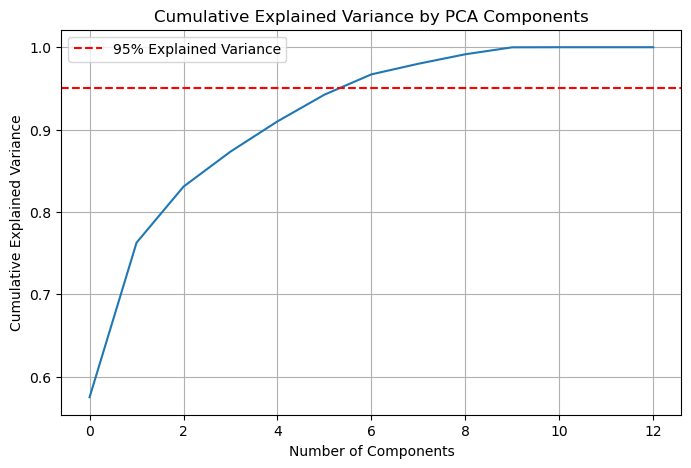

In [1410]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA on the training data
pca = PCA().fit(X_train)

# Calculate the cumulative sum of explained variances
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)

# This line draws a dashed line at 0.95 which is the threshold for the explained variance
plt.axhline(y=0.95, linestyle='--', color='red', label='95% Explained Variance')
plt.legend(loc='best')

plt.show()

Note on Principal Components:

- A principal component in the context of PCA (Principal Component Analysis) is a linear combination of the original variables. Principal components are derived in such a way that the first principal component explains the largest possible variance in the dataset. Each subsequent component explains the maximum remaining variance while being orthogonal (at a right angle in n-dimensional space) to the preceding components.

In [1411]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize PCA with 6 components
pca = PCA(n_components=6)

# Fit PCA on the training set and transform both training and testing sets
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create Naive Bayes model
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train_pca, y_train)

# Predict outcomes on testing set
y_pred = nb_model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy}")
print(report)

Model Accuracy: 0.7262569832402235
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       105
           1       0.70      0.59      0.64        74

    accuracy                           0.73       179
   macro avg       0.72      0.71      0.71       179
weighted avg       0.72      0.73      0.72       179



**Model Accuracy**: Approximately 72.63%, indicating that around 72.63% of predictions match the actual values. 

**Precision for class 0**: About 74%, which means that when the model predicts class 0, it is correct 74% of the time.

**Recall for class 0**: About 82%, indicating that the model correctly identifies 82% of all actual class 0 instances.

**F1-score for class 0**: Approximately 78%, which is a harmonic mean of precision and recall and is a measure of the model's accuracy. A higher F1-score indicates better performance.

**Precision for class 1**: Around 70%, meaning that when the model predicts class 1, it is correct 70% of the time.

**Recall for class 1**: Roughly 59%, showing that the model correctly identifies 59% of all actual class 1 instances.

**F1-score for class 1**: Approximately 64%, another indicator of accuracy.

The **support** for class 0 and 1 indicates the number of true instances for each class in the dataset (105 for class 0 and 74 for class 1).

The **macro average** will compute the metric independently for each class and then take the average (hence treating all classes equally), resulting in 72% for precision, 71% for recall, and 71% for the F1-score.

The **weighted average** will account for class imbalance by computing the metrics for each label, and find their average weighted by support (the number of true instances for each label), which is reflected in the 72% for precision, 73% for recall, and 72% for the F1-score.

In [1412]:
X = test_Data_DF.drop(['PassengerId', 'Name', 'Ticket', 'Title', 'Age','Fare'], axis=1)

X_test_reduced = pca.transform(X)
predictions = nb_model.predict(X_test_reduced)

submission_df = pd.DataFrame({
    'PassengerId': test_Data_DF['PassengerId'], 
    'Survived': predictions
})

submission_df.to_csv('./Submissions/submission3.csv', index=False)

![Alt text](image-2.png)

About a 4% performance increase!!

## An ensemble classifier using a combination of KNN, Decision Trees, and Naive Bayes models

d) Create an ensemble classifier using a combination of KNN, Decision Trees, and Naive Bayes models. Evaluate this classifier.

Ensemble models are a technique in machine learning where multiple models, often referred to as "weak learners," are strategically combined to create a "strong learner" that provides better performance than any of the individual models alone. The idea is that by combining the predictions from multiple models, the ensemble can account for individual model weaknesses and capitalize on their strengths.

We are going to use a VotingClassifier that is a type of ensemble model where the predictions of each base model are combined through voting. There are two types of voting:

- Hard Voting: In hard voting, each model gets one vote, and the prediction with the majority of votes becomes the ensemble's prediction.

- Soft Voting: If all the classifiers are able to estimate class probabilities (i.e., they have a predict_proba method), then you can predict the class with the highest class probability, averaged over all the individual classifiers.

We are going to use hard voting.

In [1413]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize the individual models with their respective best parameters
knn_model = KNeighborsClassifier(n_neighbors=9)  # 9 was found to be the best in the previous notebook
dt_model = DecisionTreeClassifier(max_depth=1)  # Using the standard model as im not sure how to integrate my one in
nb_model = GaussianNB()

# Creating a VotingClassifier with the individual models
ensemble_model = VotingClassifier(estimators=[
    ('knn', knn_model),
    ('dt', dt_model),
    ('nb', nb_model)
], voting='hard')  # 'hard' for majority voting

# Fit the ensemble classifier to the training data
ensemble_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = ensemble_model.predict(X_test)

# Evaluate the ensemble classifier on the validation set
ensemble_accuracy = ensemble_model.score(X_test, y_pred_test)
print(f"Ensemble Model Accuracy: {ensemble_accuracy}")


Ensemble Model Accuracy: 1.0


In [1414]:
from sklearn.metrics import confusion_matrix

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy: {accuracy}')

# Generate a classification report
report = classification_report(y_test, y_pred_test)
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(cm)


Accuracy: 0.7932960893854749
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

[[89 16]
 [21 53]]


In [1415]:
X = test_Data_DF.drop(['PassengerId', 'Name', 'Ticket', 'Title', 'Age','Fare'], axis=1)

# Make predictions using the fitted ensemble model
test_predictions = ensemble_model.predict(X)

# Create the submission DataFrame
submission = pd.DataFrame({
    "PassengerId": test_Data_DF["PassengerId"],  
    "Survived": test_predictions
})

# Convert to CSV for submission

submission.to_csv('./Submissions/submission_ensemble.csv', index=False)


![Alt text](image-3.png)

Another 4% increase, not bad. The accuracy on Kaggle (75.598) is a bit lower than the validation accuracy (around 79%). This could indicate that the model might be slightly overfitting to the training data or that the train and test distributions are not identical.